# Data Science Tweets-Tool-SENTER (Sentyment Twitter)

Milestone project for microcredential Associate Data Scientist held by [Kementrian pendidikan, Kebudayaan, Riset, dan Teknologi](http://diktiristek.kemdikbud.go.id/microcredential-ai/) from 01 Novembet - 10 Desember 2021 <br>

In this project, we are expected to be able to complete projects in a structured manner according to the national standard Associate Data Scientist KEMKOMINFO competence as follow :


1. Business Understanding
2. Define Business Goals
3. Data Collection
4. Data Understanding
5. Data Data Cleansing
6. Data Preprocessing
7. Model Building
8. Model Deployment



Moreover, we are challenged to solve problems in Indonesia and prohibited using data from Kaggle, UCI repository, and several other dataset sites. From this limitation, the [author](https://github.com/darkun7/tweet-tool-senter/graphs/contributors) has decided to make things more fun with connecting the project to [twitter's API](https://developer.twitter.com/en).<br><br>
The project deadline is on 17 Desember 2021 at 23.59 GMT+7 and is subject to changes before then
<br></br>
This notebook is accessible through [GitHub](https://github.com/darkun7/tweet-tool-senter), last updated 13 Desember 2021 at 16.25 GMT+7

## Business Understanding

Ensuring the success of a project often requires insight from various parties. In order to obtain the knowledge needed, digital data sources can be obtained through website pages, news portals, and social media. One of the social media that is quite busy used by the people of Indonesia is Twitter. The high interaction of Twitter users can be a benchmark for assumptions and public opinion on a topic.

## Define Business Goals

Using sentiment analysis can help determine whether a review is negative, neutral, or positive. So that analyzing this data can help understand the perspectives and opinions of the community and can help policymakers both in industry and government in making decisions, assisting business processes.
<br><br>
In this project, we will create a web application that can receive keyword input from users and process Twitter data to generate sentiment analysis of these keywords in the community.

# Data Collection

### Import Dependencies

In [1]:
import tweepy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# import StemmerFactory class
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

# Machine Learning imports
import nltk
import joblib
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer

import tensorflow as tf
import string
import re
from string import punctuation
from collections import Counter


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Dropout, LSTM
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

import networkx as nx
from networkx.readwrite import json_graph
from plotly.offline import download_plotlyjs, init_notebook_mode,  iplot, plot
init_notebook_mode(connected=True)
import plotly.figure_factory as ff

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\WINDOWS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Twitter API

You can get the twitter's API from [twitter developer](https://developer.twitter.com/en) and using `tweepy` to scrap data from twitter

In [2]:
API_Key = "______"
API_Key_Secret = '_____'
Bearer_Token = '_____'
Access_Token= '_____'
Access_Token_Secret= '_____'

client = tweepy.Client(bearer_token=Bearer_Token,
                       consumer_key=API_Key,
                       consumer_secret=API_Key_Secret,
                       access_token=Access_Token,
                       access_token_secret=Access_Token_Secret,
                       wait_on_rate_limit=True)

### Twitter Data Acquisition

For the dataset, we retrieve data using different keyword from 2021-12-06 until 2021-12-13 with keyword as follow:

- indonesia
- corona
- bts
- badminton
- juara
- semeru
- pajak

In [73]:
query = 'juara lang:id'

In [74]:
data = client.get_recent_tweets_count(query=query)

In [75]:
data.data

[{'end': '2021-12-06T02:00:00.000Z',
  'start': '2021-12-06T01:52:40.000Z',
  'tweet_count': 27},
 {'end': '2021-12-06T03:00:00.000Z',
  'start': '2021-12-06T02:00:00.000Z',
  'tweet_count': 284},
 {'end': '2021-12-06T04:00:00.000Z',
  'start': '2021-12-06T03:00:00.000Z',
  'tweet_count': 242},
 {'end': '2021-12-06T05:00:00.000Z',
  'start': '2021-12-06T04:00:00.000Z',
  'tweet_count': 263},
 {'end': '2021-12-06T06:00:00.000Z',
  'start': '2021-12-06T05:00:00.000Z',
  'tweet_count': 887},
 {'end': '2021-12-06T07:00:00.000Z',
  'start': '2021-12-06T06:00:00.000Z',
  'tweet_count': 981},
 {'end': '2021-12-06T08:00:00.000Z',
  'start': '2021-12-06T07:00:00.000Z',
  'tweet_count': 690},
 {'end': '2021-12-06T09:00:00.000Z',
  'start': '2021-12-06T08:00:00.000Z',
  'tweet_count': 605},
 {'end': '2021-12-06T10:00:00.000Z',
  'start': '2021-12-06T09:00:00.000Z',
  'tweet_count': 455},
 {'end': '2021-12-06T11:00:00.000Z',
  'start': '2021-12-06T10:00:00.000Z',
  'tweet_count': 360},
 {'end': '2

In [76]:
jumlah = 5000
count=0
message,retweet_count,retweet,created_at,user_name,user_id,type_re=[],[],[],[],[],[],[]
for i in data.data:
    try:
        if i['tweet_count'] >= 100:
            batch = 100
            tweets = client.search_recent_tweets(query=query, 
                                                 user_auth=True,
                                                 start_time=i['start'],
                                                 end_time=i['end'],
                                                 tweet_fields=['author_id','context_annotations',
                                                               'created_at','in_reply_to_user_id','public_metrics',
                                                               'referenced_tweets'],
                                                 user_fields=['username'], 
                                                 expansions='author_id',
                                                 max_results= batch)
        elif i['tweet_count'] < 10:
            batch = 10
            tweets = client.search_recent_tweets(query=query, 
                                                 user_auth=True,
                                                 start_time=i['start'],
                                                 end_time=i['end'],
                                                 tweet_fields=['author_id','context_annotations',
                                                               'created_at','in_reply_to_user_id','public_metrics',
                                                               'referenced_tweets'],
                                                 user_fields=['username'], 
                                                 expansions='author_id',
                                                 max_results= batch)
        else:
            batch = i['tweet_count']
            tweets = client.search_recent_tweets(query=query, 
                                                 user_auth=True,
                                                 start_time=i['start'],
                                                 end_time=i['end'],
                                                 tweet_fields=['author_id','context_annotations',
                                                               'created_at','in_reply_to_user_id','public_metrics',
                                                               'referenced_tweets'],
                                                 user_fields=['username'], 
                                                 expansions='author_id',
                                                 max_results=batch)
        # Get users list from the includes object
        users = {u["id"]: u for u in tweets.includes['users']}
        for i in tweets.data:
            if 'referenced_tweets' in i.data.keys():
                text = i.data['text']
                message.append(text)
                retweet_count.append(i.data['public_metrics']['retweet_count'])
                typer = i.data['referenced_tweets'][0]['type']
                if typer == 'replied_to':
                    type_re.append(typer)
                    mess = text.split()
                    retweet.append(mess[0].replace('@',''))
                else:
                    type_re.append(typer)
                    mess = text.split()
                    retweet.append(mess[1].replace('@','').replace(':',''))
                user = users[i.author_id]
                user_name.append(user.username)
                created_at.append(i.data['created_at'])
            else:
                message.append(i.data['text'])
                retweet_count.append(i.data['public_metrics']['retweet_count'])
                type_re.append(np.NaN)
                retweet.append(np.NaN)
                user = users[i.author_id]
                user_name.append(user.username)
                created_at.append(i.data['created_at'])
        count += len(tweets.data)
        print(count)
        if count > jumlah:
            break
    except:
        continue

98
195
294
362
442
533
627
723
816
908
1006
1102


Rate limit exceeded. Sleeping for 399 seconds.


1199
1297
1392
1487
1548
1583
1605
1638
1715
1779
1854
1924
1997
2085
2178
2271
2365
2460
2551
2650
2748
2843
2940
3036
3132
3229
3325
3420
3497
3588
3640
3740
3836
3932
4027
4124
4218
4315
4414
4513
4613
4712
4812
4907
5007


In [77]:
df = pd.DataFrame({'author':retweet,
                   'username':user_name,
                   'retweet_count':retweet_count,
                   'tweets':message,
                   'created_at':created_at,
                   'type':type_re})

In [78]:
df['created_at'] = pd.to_datetime(df['created_at'], format='%Y-%m-%dT%H:%M:%S.000Z', errors='ignore')

In [79]:
df

author        username  retweet_count  \
0             jangan       bluevicO1              0   
1                NaN   Dedetabdillah              0   
2                NaN         nfjuara              0   
3            convomf        milkyays              0   
4         JelemoGAJE    Tri12Anggara              0   
...              ...             ...            ...   
5002  NarasiNewsroom       ojanajima           3161   
5003      MafiaWasit        Haniif33           1698   
5004   puteelililito   Cahyaniahyarr              0   
5005     PKSejahtera    umam_chaerul             53   
5006             NaN  kabarrantaucom              0   

                                                 tweets          created_at  \
0     jangan bilang arisa enggak stabil, kalo gak st... 2021-12-06 02:59:54   
1     Baru kali ini seumur2 bikin kalkulasi juara du... 2021-12-06 02:58:39   
2     Selamat pagi, Sobat juara. \n\n#MondayMotivati... 2021-12-06 02:58:32   
3     @convomf Ada nih eunseo, anaknya ini aktif cer... 2021-12-06 02:58:30   
4     @JelemoGAJE Kalo dr power jelas Mercy di atas ... 2021-12-06 02:58:02   
...                                                 ...                 ...   
5002  RT @NarasiNewsroom: Karena mengkritisi bonus y... 2021-12-08 10:45:10   
5003  RT @MafiaWasit: Dapat kabar dari Media Malaysi... 2021-12-08 10:44:45   
5004  @puteelililito @balballan Juara 1 meungkit🙇‍♀️... 2021-12-08 10:44:36   
5005  RT @PKSejahtera: Selamat.... Untuk ketiga kali... 2021-12-08 10:44:30   
5006  Wisata Religi Bubohu Raih Juara dua kategori D... 2021-12-08 10:44:20   

            type  
0     replied_to  
1            NaN  
2            NaN  
3     replied_to  
4     replied_to  
...          ...  
5002   retweeted  
5003   retweeted  
5004  replied_to  
5005   retweeted  
5006         NaN  

[5007 rows x 6 columns]

In [80]:
df = df[df['type']!='quoted']

In [88]:
pd.set_option('display.max_colwidth', 3000)

In [89]:
df.head()

author       username  retweet_count  \
0      jangan      bluevicO1              0   
1         NaN  Dedetabdillah              0   
2         NaN        nfjuara              0   
3     convomf       milkyays              0   
4  JelemoGAJE   Tri12Anggara              0   

                                                                                                                                                                                                                    tweets  \
0                                                                                                                       jangan bilang arisa enggak stabil, kalo gak stabil gaakan dia juara b2b, gaakan masuk final io wtf   
1                                                                                                                      Baru kali ini seumur2 bikin kalkulasi juara dunia F1 cuma "dia yang di depan, dia yang juara dunia"   
2                                                                                                                                                 Selamat pagi, Sobat juara. \n\n#MondayMotivation https://t.co/IKub5MkdEW   
3                                        @convomf Ada nih eunseo, anaknya ini aktif ceria gitu mana cantik mukanya, hidungnya mancung, juara lari, bisa gulat, actress juga, tinggi, body goals😭🤲🏻 https://t.co/ZaMwLiruWT   
4  @JelemoGAJE Kalo dr power jelas Mercy di atas angin dgn mudah gapai juara dunia apalagi kl dpt pole tp apapun bs terjadi. Ya kita liat aja sapa yg bernasib lbh untung di sana krn saya emg ga dukung Max atau Lewis 😄😄   

           created_at        type  
0 2021-12-06 02:59:54  replied_to  
1 2021-12-06 02:58:39         NaN  
2 2021-12-06 02:58:32         NaN  
3 2021-12-06 02:58:30  replied_to  
4 2021-12-06 02:58:02  replied_to

In [82]:
df = df.drop_duplicates('tweets')
df.shape

(2351, 6)

In [83]:
df.author.value_counts()

idextratime       33
ainurohman        16
convomf           12
INABadminton      10
SiaranBolaLive     9
                  ..
indihomeborneo     1
Kenapa             1
theViniciusJr      1
Mohrefaldo         1
acilranggers       1
Name: author, Length: 1171, dtype: int64

In [84]:
df.to_csv("juara_dataset.csv",index=False)

## Data Understanding

Data that have been retrieve will be unified so that it becomes more general for training purposes. There are 17308 row data that will be use with information of author, username, retweet_count, tweets, created_at, and type.


Twitter data are included in unstructured data that has a lot of noise such as punctuation, urls, links, mentions, lowercase, uppercase, etc. The dataset also has no labels, so we need a lot of preproses step for this fiuuhh... 

In [85]:
df1 = pd.read_csv("indonesia_dataset.csv")
df2 = pd.read_csv("corona_dataset.csv")
df3 = pd.read_csv("bts_dataset.csv")
df4 = pd.read_csv("badminton_dataset.csv")
df5 = pd.read_csv("juara_dataset.csv")
df6 = pd.read_csv("semeru_dataset.csv")
df7 = pd.read_csv("pajak_dataset.csv")

df_all = pd.concat([df1,df2,df3,df4,df5,df6,df7], axis=0)
df_all = df_all.drop_duplicates('tweets')
df_all.shape

(17308, 6)

In [86]:
df_all.to_csv("all_dataset.csv",index=False)

In [90]:
df_all.head()

author        username  retweet_count  \
0       RJLetsGo        taeckrmn            980   
1       detikcom   Makcomblang18              0   
2            NaN  PolsekPancoran              0   
3  jokitugasfess      hayuknugas              0   
4    irmluthfiya    _mahdalena22             48   

                                                                                                                                                                                                                                                                    tweets  \
0                                                                                                                                                                                        RT @RJLetsGo: Donasi army Indonesia, untuk bencana Gunung Semeru \n\n- a thread -   
1                                                                                                                                  @detikcom ko gitu mending ikut Tarkam aja,,endingnya Indonesia bahkan bisa nyerah ke negara tetangga..hadianya (duit) mayan juga ..haha   
2                                       Polri Terus Evakuasi Masyarakat Terdampak Erupsi Gunung Semeru\n\nKepolisian Negara Republik Indonesia (Polri) terus mengerahkan prajuritnya untuk mengevakuasi masyarakat terdampak erupsi Gunung Semeru. https://t.co/hIS1olX3AD   
3  @jokitugasfess 🦥HALOOW!🦥\naku bisa bantu kamu nih. \n✨aku mahasiswa Sastra Indonesia, jadi tugas kamu udah pasti berkualitas! ✨\nCek Testi di sini:\nhttps://t.co/NCXmDuDotc\nWA kami di sini:\nhttps://t.co/yqXntUoQi0\n\nuntuk tugas kamu V START:\n💸8k isian panjang   
4                                                                                                                           RT @irmluthfiya: PENCEGAHAN BUNUH DIRI DI INDONESIA￼\n\nKita semua sudah familiar dengan hotline 911 yang ada di Amerika. Namun, siapa sangka…   

            created_at        type  
0  2021-12-06 02:59:59   retweeted  
1  2021-12-06 02:59:59  replied_to  
2  2021-12-06 02:59:56         NaN  
3  2021-12-06 02:59:55  replied_to  
4  2021-12-06 02:59:53   retweeted

## Data Cleansing and Preprocessing

In this step we will do: 
1. case folding to remove noise from data
2. removing stopwors
3. stemming to retrieve the basic word from tweets
4. labeling with lexicon
5. visualize some of the data

### Case Folding

In [91]:
# helper function to clean tweets
def processTweet(tweet):
    # Remove HTML special entities (e.g. &amp;)
    tweet = re.sub(r'\&\w*;', '', tweet)
    #Convert @username to AT_USER
    tweet = re.sub('@[^\s]+','',tweet)
    # Remove tickers
    tweet = re.sub(r'\$\w*', '', tweet)
    # To lowercase
    tweet = tweet.lower()
    # Remove hyperlinks
    tweet = re.sub(r'https?:\/\/.*\/\w*', '', tweet)
    # Remove hashtags
    tweet = re.sub(r'#\w*', '', tweet)
    # Remove Punctuation and split 's, 't, 've with a space for filter
    tweet = re.sub(r'[' + punctuation.replace('@', '') + ']+', ' ', tweet)
    # Remove words with 2 or fewer letters
    tweet = re.sub(r'\b\w{1,2}\b', '', tweet)
    # Remove whitespace (including new line characters)
    tweet = re.sub(r'\s\s+', ' ', tweet)
    # Remove single space remaining at the front of the tweet.
    tweet = tweet.lstrip(' ') 
    # Remove characters beyond Basic Multilingual Plane (BMP) of Unicode:
    tweet = ''.join(c for c in tweet if c <= '\uFFFF')
    return tweet

In [92]:
# clean dataframe's text column
df_all['tweet_preprocessed'] = df_all['tweets'].apply(processTweet)

### Stop Words

In [93]:
factory = StopWordRemoverFactory()
stopwords = factory.get_stop_words()

In [94]:
from nltk.corpus import stopwords
listStopwords = set(stopwords.words('indonesian'))
listStopwords = list(listStopwords)

In [95]:
factory = StopWordRemoverFactory()
stopword = factory.create_stop_word_remover()

def stoptweet(tweet):
    tweet = stopword.remove(tweet)
    filtered = []
    for txt in tweet:
        if txt not in listStopwords:
            filtered.append(txt)
    text = filtered 
    return tweet

In [96]:
df_all['tweet_preprocessed'] = df_all['tweet_preprocessed'].apply(stoptweet)

## Stemming

In [97]:
# create stemmer
factory = StemmerFactory()
stemmer = factory.create_stemmer()

In [98]:
# helper function to clean tweets
def stemtweet(tweet):
  tweet = stemmer.stem(tweet)
  return tweet

In [99]:
# clean dataframe's text column
df_all['tweet_preprocessed'] = df_all['tweet_preprocessed'].apply(stemtweet)

In [100]:
df_all.to_csv("all_data_preprocessed.csv",index=False)

In [33]:
df = pd.read_csv("all_data_preprocessed.csv")
df

author         username  retweet_count  \
0             RJLetsGo         taeckrmn            980   
1             detikcom    Makcomblang18              0   
2                  NaN   PolsekPancoran              0   
3        jokitugasfess       hayuknugas              0   
4          irmluthfiya     _mahdalena22             48   
...                ...              ...            ...   
17303      DaengKayo89          dytyano              0   
17304       matakudoea  GunGunG49169853              0   
17305       AlbaSanto_  GunGunG49169853              0   
17306  suwito_abdullah          dytyano              0   
17307     tatakujiyati  GunGunG49169853              4   

                                                                                                                                                                                                                                                                        tweets  \
0                                                                                                                                                                                            RT @RJLetsGo: Donasi army Indonesia, untuk bencana Gunung Semeru \n\n- a thread -   
1                                                                                                                                      @detikcom ko gitu mending ikut Tarkam aja,,endingnya Indonesia bahkan bisa nyerah ke negara tetangga..hadianya (duit) mayan juga ..haha   
2                                           Polri Terus Evakuasi Masyarakat Terdampak Erupsi Gunung Semeru\n\nKepolisian Negara Republik Indonesia (Polri) terus mengerahkan prajuritnya untuk mengevakuasi masyarakat terdampak erupsi Gunung Semeru. https://t.co/hIS1olX3AD   
3      @jokitugasfess 🦥HALOOW!🦥\naku bisa bantu kamu nih. \n✨aku mahasiswa Sastra Indonesia, jadi tugas kamu udah pasti berkualitas! ✨\nCek Testi di sini:\nhttps://t.co/NCXmDuDotc\nWA kami di sini:\nhttps://t.co/yqXntUoQi0\n\nuntuk tugas kamu V START:\n💸8k isian panjang   
4                                                                                                                               RT @irmluthfiya: PENCEGAHAN BUNUH DIRI DI INDONESIA￼\n\nKita semua sudah familiar dengan hotline 911 yang ada di Amerika. Namun, siapa sangka…   
...                                                                                                                                                                                                                                                                        ...   
17303                                                                                                                                                          @DaengKayo89 @tvOneNews tapi bukan uang pajak jakarta  x ngibul z kerjanya.. hahahah... https://t.co/mWQpeMASBK   
17304                                                                                     @matakudoea @tatakujiyati @pengarang_sajak @DKIJakarta Kok pada kepanasan? 😁\n\nGubernur Anies: JIS Bukan Hadiah Perusahaan, Tapi dari Pajak Rakyat Jakarta  https://t.co/10OIHgpAPP   
17305                                                                                                                          @AlbaSanto_ @tatakujiyati @pengarang_sajak Gubernur Anies: JIS Bukan Hadiah Perusahaan, Tapi dari Pajak Rakyat Jakarta  https://t.co/10OIHgpAPP   
17306                                                                                                                                                                                @suwito_abdullah @tvOneNews kata siapa dari pajak drun....Hahaha  https://t.co/mWQpeMASBK   
17307                                                                                                                              RT @tatakujiyati: @pengarang_sajak Kayak gini kok dipertentangkan? Kedua informasi benar, tak saling menegasikan. Benar sebagian pendanaan…   

                created_at    

In [34]:
df = df.drop_duplicates('tweets')
df.shape

(17308, 7)

In [35]:
df = df.dropna(subset=['tweet_preprocessed'])

In [36]:
df.shape

(17261, 7)

### Labeling Lexicon

In [37]:
# Determine sentiment polarity of tweets using indonesia sentiment lexicon (source : https://github.com/fajri91/InSet)

# Loads lexicon positive and negative data
lexicon_positive = dict()
import csv
with open('InSet-master/positif.csv', 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=';')
    for row in reader:
        if row[1].isalpha():
            continue
        else:
            lexicon_positive[row[0]] = int(row[1])

lexicon_negative = dict()
import csv
with open('InSet-master/negatif.csv', 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=';')
    for row in reader:
        if row[1].isalpha():
            continue
        else:
            lexicon_negative[row[0]] = int(row[1])
        
# Function to determine sentiment polarity of tweets        
def sentiment_analysis_lexicon_indonesia(text):
    #for word in text:
    score = 0
    text = text.split()
    for word in text:
        if (word in lexicon_positive):
            score = score + lexicon_positive[word]
    for word in text:
        if (word in lexicon_negative):
            score = score + lexicon_negative[word]
    polarity=''
    if (score > 0):
        polarity = 'positive'
    elif (score < 0):
        polarity = 'negative'
    else:
      
        polarity = 'neutral'
    return score, polarity

In [38]:
# Results from determine sentiment polarity of tweets
results = df['tweet_preprocessed'].apply(sentiment_analysis_lexicon_indonesia)
results = list(zip(*results))
df['polarity_score'] = results[0]
df['polarity'] = results[1]
print(df['polarity'].value_counts())

negative    9707
positive    5024
neutral     2530
Name: polarity, dtype: int64


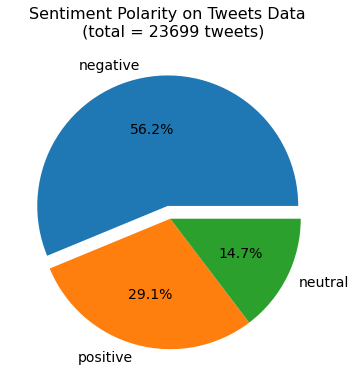

In [39]:
fig, ax = plt.subplots(figsize = (6, 6))
sizes = [count for count in df['polarity'].value_counts()]
labels = list(df['polarity'].value_counts().index)
explode = (0.1, 0, 0)
ax.pie(x = sizes, labels = labels, autopct = '%1.1f%%', explode = explode, textprops={'fontsize': 14})
ax.set_title('Sentiment Polarity on Tweets Data \n (total = 23699 tweets)', fontsize = 16, pad = 20)
plt.show()

### Top 10 tweet positif

In [40]:
pd.set_option('display.max_colwidth', 3000)
positive_df = df[df['polarity'] == 'positive']
positive_df = positive_df[['tweets', 'polarity_score', 'polarity']].sort_values(by = 'polarity_score', ascending=False).reset_index(drop = True)
positive_df.index += 1
positive_df[0:10]

tweets  \
1     Solusi untuk AC MILAN Januari 2022\nBek sempurna kualitas oke nilai WAH\n1. SPINAZZOLLA\n    NILAI 25 JUTA €\n    KUALITAS 95\n    JUARA EROPA\n2. TOLOI\n     NILAI 15 JUTA €\n     KUALITAS 75\n     4 BESAR SERIE A\n3. CAIO\n     NILAI 40 JUTA €\n     KUALITAS 70\n     FINALIS LIBERTADORES   
2              https://t.co/9Ckp7sjQvg\n\n081330630920 : jasa pengecatan lapangan futsal Surabaya, jasa pengecatan lapangan surabaya, jasa pengecatan lapangan sepak bola surabaya,jasa pengecatan lapangan basket surabaya,jasa pengecatan lapangan badminton surabaya, jasa pengecatan lantai surabaya   
3     @BadmintonTalk Good fight Minions! Tetap semangat &amp; good luck utk pertandingan berikutnya yak! Kalian keren abis! Selamat istirahat!\n\nhttps://t.co/JUAlVesF4T\n\nOh iya, buat kalian yang jg pengen jago main badminton, yuk sering2 latihan dengan raket YONEX ini!\n\n#WorldTourFinals2021   
4                                                                    Ketika itu, peminat dari game ini langsung membludak terus meningkat sampai saat ini. Dalam sejarah, Mobile Legends berhasil memenangkan penghargaan Most Favorite Game of the Year pada gelaran Indonesia Gaming Awards 2019 lalu.   
5                 bayar pajak, cuman dipake buat bayarin buzzer yang nyatanya gak efektif.\n\ndaripada berlomba bangun citra di medsos, lebih baik lagi kalo sumber dana nya dipake buat perbaikan kinerja struktur. \n\nbuat apa citra medsos kalo masyarakat juga bakal tetep gapercaya sama struktur.   
6                                                                                                                                                                 @Adrafaela_ @BTS_twt HEYYY! you have us babe, happy birthday to u! terima kasih telah lahir ke duniaaa, panjang umur dan sehat selalu💜   
7                    H - tau ngga, rasanya mau teriak aja kalau liat kamu, beneran. You have no idea how much I love Bill. Kaget juga karena jarang yang pake, kayaknya kamu satu-satunya. So that, I would like to say thank you. MAKASIH YAAAA. Seneng banget. Oh iya, sama-sama suka badminton! Asik.   
8   @athena_tsimikas Hi kak, Selain untuk menciptakan perusahaan yang lebih kuat juga akan memberikan manfaat lebih bagi Pelanggan, mendorong inovasi, peningkatan kualitas pelayanan bagi Pelanggan, yang akan menguntungkan pelanggan serta mendukung percepatan transformasi digital Indonesia. ^Jane   
9                                                      Terima kasih juga kepada seluruh atlet yang telah memenangkan pertandingan ini dan bagi para pejuang tangguh Badminton Indonesia yang masih belum beruntung, tetap semangat. Kalian telah bekerja keras untuk mengharumkan nama Bangsa Indonesia.   
10     @BadmintonTalk Semangat terus buat para Atlet Badminton INA, semoga Tuhan YME senantiasa memberikan kesehatan, cepet pulih dari lelahnya turnamen beruntun kemarin, dan terhindar dari virus. Tetap semangat untuk mempersiapkan ke turnamen selanjutnya dan selamat berkumpul dengan keluarga 😊😊   

    polarity_score  polarity  
1               47  positive  
2               36  positive  
3               31  positive  
4               27  positive  
5               26  positive  
6               25  positive  
7               25  positive  
8               24  positive  
9               24  positive  
10              24  positive

### Top 10 tweet negatif

In [41]:
pd.set_option('display.max_colwidth', 3000)
negative_df = df[df['polarity'] == 'negative']
negative_df = negative_df[['tweets', 'polarity_score', 'polarity']].sort_values(by = 'polarity_score', ascending=True)[0:10].reset_index(drop = True)
negative_df.index += 1
negative_df[0:10]

tweets  \
1             @t_defri @bandy_hudiharto @PutraWadapi Sebelum november 2019 semua negara tdk ada yg memprediksi akan merebaknya pandemi virus corona...bandar udara rata rata di bangun sebelum pandemi.. Dan selesai pas pandemi merebak menghantam seluruh dunia... Semua negara terkena imbasnya bukan hanya negara kita...   
2                         ngentot video download # \nbokep.indonesia # \nvideo bercumbu # \nvidio bokep xxx # \ndownload film bokep indo # \nlink download video bokep # \nkokep korea # \nbokeep hot # \nmama bokep # ...  #\nflm bokep # #\nartis dangdut bokep # #\nvedio bokep online # #\nbokep… https://t.co/tadGGiMlg3   
3                                    Upaya pencarian terhenti Senin pagi akibat hujan deras di area puncak dan angin kencang di area pencarian. "Potensi aliran air dari atas dikhawatirkan membahayakan, mengingat akses ke lokasi hanya satu dan cuaca buruk dikhawatirkan merobohkan jembatan."\n\nhttps://t.co/UmBky2X1iG   
4                                                                                       Capek ajg denger berita pemerkosaan, korupsi, pajak, pangkas ini itu, covid\n\nGada gtu berita hutang indonesia lunas ?\nTunjangan untuk rakyat miskin dan pengangguran?\nBebas pajak\nTidak banjir, mentri capres dll tidak pansos ?   
5                                          @democrazymedia Bukan nya sekarang program itu dah mulai di jalankan,entaskan kemiskinan dlm waktu sesingkat singkat nya dgn cara peras keringat orang miskin dgn pajak menjulang,biar mampus sekalian kami yg miskin ini kalau kami dah mati semua kan otomatis kemiskinan hilang   
6   @maidina__ @RichartVolx RV pembayar pajak, buat apa masuk penjara? Resiko kena covid juga besar? \nHahaha.. 😁😁😁\nSementara yg lain resikonya lbh kecil ya? \nYa mungkin karena RV pembayar pajak besar, sementara yg lain pembayar pajak kecil bisa di asumsikan sesuai dgn bsr kecilnya pajak... https://t.co/YvLxDroNaU   
7                                                                                                 Berita tentang kematian terus bermunculan ada yang mati karena corona, kecelakaan ada karena sakit ada yang tiba2 mati tanpa diketahui sababnya semuanya tinggalkan dunia ini dan mereka semua kami kuburkan dan itu pasti.   
8                                                      @tubirfess Kebiri aja ga cukup. Kalo otaknya dah cabul, dikebiri sekalipun dia masih bisa melecehkan orang lain\n\nPaling bener ditembak mati sih yg beginian biar ga bikin penuh penjara. Soalnya gue ga rela juga dia di penjara dapet makan dari duit pajak kita :)   
9                                                                                                                                    https://t.co/KOVDCPyWn4 Tax ratio kita rendah dan trennya terus menurun. Berisiko atau tidaknya lonjakan utang menurut saya ada risiko, mengingat kemampuan pajak kita rendah," tukasnya   
10                                       Sedikit curahan hati gue sebagi anak dari orang tua yang sangat religius\nIni udah gue terjemahan ke bahasa indo ya, karna gue orang sunda\nMe: ayah, to'un itu apa?\nAyah:penyakit kaya Corona tapi lebih parah dan berbahaya\nMe: oh berarti virus\nAyah: iya, berbahaya banget --   

    polarity_score  polarity  
1              -54  negative  
2              -49  negative  
3              -48  negative  
4              -48  negative  
5              -48  negative  
6              -44  negative  
7              -43  negative  
8              -43  negative  
9              -43  negative  
10             -42  negative

### Visualization

#### Word Cloud

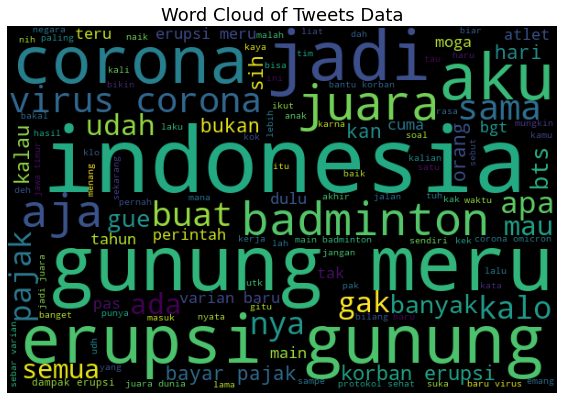

In [42]:
# Visualize word cloud

list_words=''
for tweet in df['tweet_preprocessed']:
    tweet = tweet.split()
    for word in tweet:
        list_words += ' '+(word)
        
wordcloud = WordCloud(width = 600, height = 400, background_color = 'black', min_font_size = 10).generate(list_words)
fig, ax = plt.subplots(figsize = (8, 6))
ax.set_title('Word Cloud of Tweets Data', fontsize = 18)
ax.grid(False)
ax.imshow((wordcloud))
fig.tight_layout(pad=0)
ax.axis('off')
plt.show()

## Model Building

### Tokenize

In [43]:
# Make text preprocessed (tokenized) to untokenized with toSentence Function
X = df['tweet_preprocessed'] 
max_features = 5000

# Tokenize text with specific maximum number of words to keep, based on word frequency
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(X.values)
X = tokenizer.texts_to_sequences(X.values)
X = pad_sequences(X)
X.shape

(17261, 41)

In [44]:
# Encode target data into numerical values
polarity_encode = {'negative' : 0, 'neutral' : 1, 'positive' : 2}
y = df['polarity'].map(polarity_encode).values

# Split the data (with composition data train 80%, data test 20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(13808, 41) (13808,)
(3453, 41) (3453,)


### LSTM model building

In [45]:
class Callback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('accuracy')>0.95:
      print("\nAkurasi telah mencapai >95%!")
      self.model.stop_training = True

In [46]:
# Create model function with default hyperparameter values

def create_model(embed_dim, hidden_unit, dropout_rate, optimizers, learning_rate):
    model = Sequential()
    model.add(Embedding(input_dim = max_features, output_dim = embed_dim, input_length = X_train.shape[1]))
    model.add(LSTM(units = hidden_unit, return_sequences=True, activation = 'tanh'))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units = hidden_unit, activation = 'tanh'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units = 3, activation = 'softmax'))
    model.compile(loss = 'sparse_categorical_crossentropy', optimizer = optimizers(lr = learning_rate), metrics = ['accuracy'])
    print(model.summary())
    return model

In [47]:
# Create the model with the best hyperparameter which has been determined
model = KerasClassifier(build_fn = create_model,
                        # Model Parameters
                        dropout_rate = 0.2,
                        embed_dim = 32,
                        hidden_unit = 16,
                        optimizers = tf.keras.optimizers.RMSprop,
                        learning_rate = 0.001,
                   
                        # Fit Parameters
                        epochs=25, 
                        batch_size=128,
                        # Initiate validation data, which is 10% data from data train. It's used for evaluation model
                        validation_split = 0.1)
                         

model_prediction = model.fit(X_train, y_train,callbacks=[Callback()])

C:\Users\WINDOWS\anaconda3\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 41, 32)            160000    
_________________________________________________________________
lstm_2 (LSTM)                (None, 41, 16)            3136      
_________________________________________________________________
dropout_2 (Dropout)          (None, 41, 16)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 16)                2112      
_________________________________________________________________
dropout_3 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 51        
Total params: 165,299
Trainable params: 165,299
Non-trainable params: 0
________________________________________________

### Confusion Matrix

C:\Users\WINDOWS\anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning:

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).



Model Accuracy on Test Data: 0.840139009556907


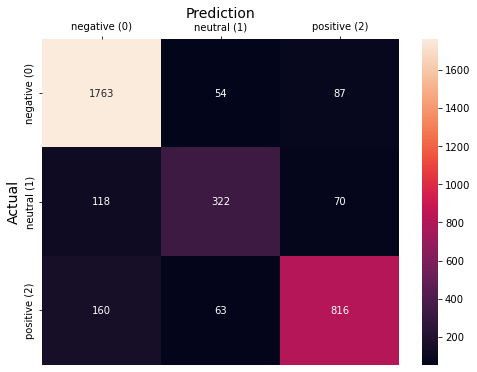

In [48]:
# Predict sentiment on data test by using model has been created, and then visualize a confusion matrix
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print('Model Accuracy on Test Data:', accuracy)
confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize = (8,6))
sns.heatmap(confusion_matrix(y_true = y_test, y_pred = y_pred), fmt = 'g', annot = True)
ax.xaxis.set_label_position('top')
ax.xaxis.set_ticks_position('top')
ax.set_xlabel('Prediction', fontsize = 14)
ax.set_xticklabels(['negative (0)', 'neutral (1)', 'positive (2)'])
ax.set_ylabel('Actual', fontsize = 14)
ax.set_yticklabels(['negative (0)', 'neutral (1)', 'positive (2)'])
plt.show()

In [49]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.93      0.89      1904
           1       0.73      0.63      0.68       510
           2       0.84      0.79      0.81      1039

    accuracy                           0.84      3453
   macro avg       0.81      0.78      0.79      3453
weighted avg       0.84      0.84      0.84      3453



### History Model

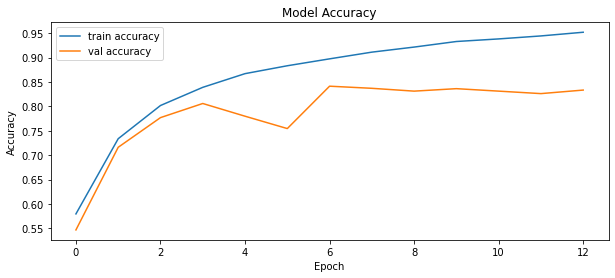

In [22]:
fig, ax = plt.subplots(figsize = (10, 4))
ax.plot(model_prediction.history['accuracy'], label = 'train accuracy')
ax.plot(model_prediction.history['val_accuracy'], label = 'val accuracy')
ax.set_title('Model Accuracy')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.legend(loc = 'upper left')
plt.show()

## Save Model

In [122]:
model_prediction.model.save("lstm_model.h5")

## Load Model

In [27]:
model = tf.keras.models.load_model("lstm_model.h5")

## Prediction

In [28]:
y_pred = model.predict(X_test)

In [29]:
pred = []
for i in y_pred:
    if i[0] == max(i):
        pred.append(0)
    elif i[1] == max(i):
        pred.append(1)
    else:
        pred.append(2)

In [30]:
neg = pred.count(0)
net = pred.count(1)
pos = pred.count(2)

print(f'Model predictions: Positives - {pos}, Negatives - {neg}, Neutrals - {net}')

Model predictions: Positives - 992, Negatives - 1993, Neutrals - 468


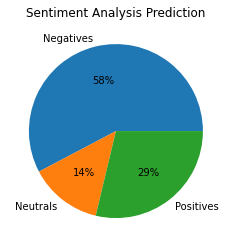

In [31]:
#define data
data = [neg, net, pos]
labels = ['Negatives', 'Neutrals', 'Positives']

#define Seaborn color palette to use

#create pie chart
plt.pie(data, labels = labels, autopct='%.0f%%')
plt.title("Sentiment Analysis Prediction")
plt.savefig('test.png', format='png',bbox_inches='tight',dpi=200)
plt.show()

# Social Network Analysis

In [2]:
df = pd.read_csv('all_dataset.csv')
df

author         username  retweet_count  \
0             RJLetsGo         taeckrmn            980   
1             detikcom    Makcomblang18              0   
2                  NaN   PolsekPancoran              0   
3        jokitugasfess       hayuknugas              0   
4          irmluthfiya     _mahdalena22             48   
...                ...              ...            ...   
17303      DaengKayo89          dytyano              0   
17304       matakudoea  GunGunG49169853              0   
17305       AlbaSanto_  GunGunG49169853              0   
17306  suwito_abdullah          dytyano              0   
17307     tatakujiyati  GunGunG49169853              4   

                                                  tweets           created_at  \
0      RT @RJLetsGo: Donasi army Indonesia, untuk ben...  2021-12-06 02:59:59   
1      @detikcom ko gitu mending ikut Tarkam aja,,end...  2021-12-06 02:59:59   
2      Polri Terus Evakuasi Masyarakat Terdampak Erup...  2021-12-06 02:59:56   
3      @jokitugasfess 🦥HALOOW!🦥\naku bisa bantu kamu ...  2021-12-06 02:59:55   
4      RT @irmluthfiya: PENCEGAHAN BUNUH DIRI DI INDO...  2021-12-06 02:59:53   
...                                                  ...                  ...   
17303  @DaengKayo89 @tvOneNews tapi bukan uang pajak ...  2021-12-12 21:06:58   
17304  @matakudoea @tatakujiyati @pengarang_sajak @DK...  2021-12-12 21:06:36   
17305  @AlbaSanto_ @tatakujiyati @pengarang_sajak Gub...  2021-12-12 21:05:46   
17306  @suwito_abdullah @tvOneNews kata siapa dari pa...  2021-12-12 21:03:16   
17307  RT @tatakujiyati: @pengarang_sajak Kayak gini ...  2021-12-12 21:02:36   

             type  
0       retweeted  
1      replied_to  
2             NaN  
3      replied_to  
4       retweeted  
...           ...  
17303  replied_to  
17304  replied_to  
17305  replied_to  
17306  replied_to  
17307   retweeted  

[17308 rows x 6 columns]

In [3]:
df = df.dropna()

In [4]:
net = nx.from_pandas_edgelist(df, source="author", target="username")

In [5]:
G = nx.convert_node_labels_to_integers(net, first_label=0, ordering='default', label_attribute=None)
pos=nx.fruchterman_reingold_layout(G)
#create labels
poslabs=nx.fruchterman_reingold_layout(net)
labels=list(poslabs) + list(' : ')
#create edges
Xe=[]
Ye=[]
for e in G.edges():
    Xe.extend([pos[e[0]][0], pos[e[1]][0], None])
    Ye.extend([pos[e[0]][1], pos[e[1]][1], None])
trace_edges=dict(type='scatter',
                 mode='lines',
                 x=Xe,
                 y=Ye,
                 line=dict(width=1, color='rgb(25,25,25)'),
                 hoverinfo='none' 
                )

#create nodes
Xn=[pos[k][0] for k in range(len(pos))]
Yn=[pos[k][1] for k in range(len(pos))]
trace_nodes=dict(type='scatter',
                 x=Xn, 
                 y=Yn,
                 mode='markers',
                 marker=dict(showscale=True,size=5,color=[],colorscale='Rainbow',reversescale=True,colorbar=dict(
                    thickness=15,
                    title='Node Connections',
                    xanchor='left',
                    titleside='right')),
                 text=labels,
                 hoverinfo='text')

#scale color by size
for node, adjacencies in enumerate(G.adjacency()):
    trace_nodes['marker']['color']+=tuple([len(adjacencies[1])])
#plot
axis=dict(showline=False, # hide axis line, grid, ticklabels and  title
          zeroline=False,
          showgrid=False,
          showticklabels=False,
          title='' 
          )
layout=dict(title= 'Social Network Analysis',  
            font= dict(family='Balto'),
            width=1000,
            height=1000,
            autosize=False,
            showlegend=False,
            xaxis=axis,
            yaxis=axis,
            margin=dict(l=40,r=40,b=85,t=100,pad=0,
            ),
            hovermode='closest',
#     plot_bgcolor='#000000',           
    )
fig = dict(data=[trace_edges,trace_nodes], layout=layout)
#run plot
iplot(fig)
plot(fig, filename='myplot1.html')

'myplot1.html'

## Deployment

The deployment of this model will be using Heroku platform as a service and can be accesed on [this GitHub](https://github.com/darkun7/tweet-tool-senter). Hope this work will be helpfull somehow..  :v